In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.utils import simple_preprocess

import spacy

import re
import json
from html.parser import HTMLParser
from io import StringIO

In [6]:
train_data = pd.read_json('../input/dataset_fr_train.json', lines=True)

test_data = pd.read_json('../input/dataset_fr_test.json', lines=True)

valid_data= pd.read_json('../input/dataset_fr_dev.json', lines=True)

In [7]:
train = train_data[train_data['stars'] != 3]
test = test_data[test_data['stars'] != 3]
valid = valid_data[valid_data['stars'] != 3]

In [8]:
# convert starts into sentiments

sentiments_dict = {1: 0,
            2: 0,
            4: 1,
            5: 1}

def stars_to_sentiment(dataset):
    dataset['sentiment'] = dataset['stars'].map(sentiments_dict)
    dataset = dataset[['review_body','sentiment']]
    return dataset

df_train = stars_to_sentiment(train)
df_test = stars_to_sentiment(test)
df_valid = stars_to_sentiment(valid)

<ipython-input-8-d8904f2187be>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sentiment'] = dataset['stars'].map(sentiments_dict)


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras import models, layers, optimizers
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras import metrics

import bz2
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import re

%matplotlib inline

In [10]:
train_labels, train_texts = df_train['sentiment'].values.tolist(), df_train['review_body'].values.tolist()
test_labels, test_texts = df_test['sentiment'].values.tolist(), df_test['review_body'].values.tolist()
val_labels, val_texts = df_valid['sentiment'].values.tolist(), df_valid['review_body'].values.tolist()

In [11]:
import re
NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')
def normalize_texts(texts):
    normalized_texts = []
    for text in texts:
        lower = text.lower()
        no_punctuation = NON_ALPHANUM.sub(r' ', lower)
        no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
        normalized_texts.append(no_non_ascii)
    return normalized_texts
        
train_texts = normalize_texts(train_texts)
test_texts = normalize_texts(test_texts)
val_texts = normalize_texts(val_texts)

In [12]:
MAX_FEATURES = 12000
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_texts)
train_texts = tokenizer.texts_to_sequences(train_texts)
val_texts = tokenizer.texts_to_sequences(val_texts)
test_texts = tokenizer.texts_to_sequences(test_texts)

In [13]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

train_texts = pad_sequences(train_texts, padding='post', maxlen=maxlen)
test_texts = pad_sequences(test_texts, padding='post', maxlen=maxlen)
val_texts = pad_sequences(val_texts, padding='post', maxlen=maxlen)

In [14]:
# preparing the embedding dictionnary

import spacy
nlp = spacy.load('fr_core_news_lg', disable=['parser', 'ner'])

In [15]:
# tqdm for showing progress
from tqdm import tqdm_notebook as tqdm

In [16]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, index in tqdm(tokenizer.word_index.items()):
    embedding_vector = nlp(word).vector
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

<ipython-input-16-dfc4edbcbecf>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for word, index in tqdm(tokenizer.word_index.items()):


  0%|          | 0/43857 [00:00<?, ?it/s]

In [19]:
def create_model(dropout=0.4, gru_nparams=128, dense_nparams=64, activation='relu', optimizer='adam'):
    sequences = layers.Input(shape=(maxlen,))
    embedded = layers.Embedding(vocab_size,
                            300,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=False)(sequences)
#     x = layers.GRU(gru_nparams)(embedded)
#     x = layers.Dense(dense_nparams, activation=activation)(x)
    x = layers.GRU(128, return_sequences=True)(embedded)
    x = layers.GRU(128)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            'binary_accuracy', 
            metrics.Precision(), 
            metrics.Recall()]
    )
    return model

gru_model = create_model()

In [20]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

my_callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0, 
                         patience=5, verbose=1, mode='auto',
                         baseline=None, restore_best_weights=True),
    ModelCheckpoint(filepath='../saved models/gru_model_binary.h5', 
                   monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max'),
    TensorBoard(log_dir='./logs'),
]

In [21]:
history = gru_model.fit(
    np.array(train_texts), 
    np.array(train_labels), 
    batch_size=128,
    epochs=50,
    validation_data=(np.array(val_texts), np.array(val_labels)),
    callbacks=[my_callbacks], )

Epoch 1/50
1250/1250 [==============================] - 256s 203ms/step - loss: 0.6902 - binary_accuracy: 0.5044 - precision: 0.5040 - recall: 0.5522 - val_loss: 0.6549 - val_binary_accuracy: 0.5690 - val_precision: 0.9395 - val_recall: 0.1475

Epoch 00001: val_binary_accuracy improved from -inf to 0.56900, saving model to ../saved models/gru_model_binary.h5
Epoch 2/50
1250/1250 [==============================] - 252s 201ms/step - loss: 0.6507 - binary_accuracy: 0.5774 - precision: 0.7004 - recall: 0.2705 - val_loss: 0.5049 - val_binary_accuracy: 0.7448 - val_precision: 0.7361 - val_recall: 0.7630

Epoch 00002: val_binary_accuracy improved from 0.56900 to 0.74475, saving model to ../saved models/gru_model_binary.h5
Epoch 3/50
1250/1250 [==============================] - 253s 203ms/step - loss: 0.3475 - binary_accuracy: 0.8488 - precision: 0.8675 - recall: 0.8234 - val_loss: 0.2902 - val_binary_accuracy: 0.8795 - val_precision: 0.9012 - val_recall: 0.8525

Epoch 00003: val_binary_accura

In [23]:
preds = gru_model.predict(test_texts)
print('Accuracy score: {:0.4}'.format(accuracy_score(test_labels, 1 * (preds > 0.5))))
print('F1 score: {:0.4}'.format(f1_score(test_labels, 1 * (preds > 0.5))))
print('ROC AUC score: {:0.4}'.format(roc_auc_score(test_labels, preds)))

Accuracy score: 0.9052
F1 score: 0.9039
ROC AUC score: 0.962


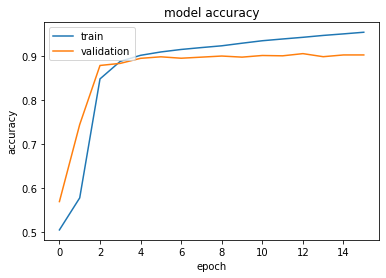

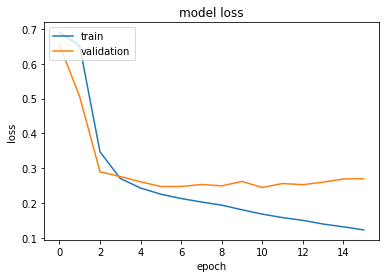

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()